# 🌟 Assignment 2. Operation "AI GeoGuessr"

### Deadline: Friday, October 24, 2025, 11:59:00 PM CET (GMT +2)

## 🎯 Mission Overview

The operation consists of two independent missions. Similar to the previous operation, students are required to solve the tasks by achieving the required score and answering the follow-up questions.

## 🧪 Neural Networks and Unsupervised Learning

1. **Mission 2.1 (Supervised Learning)**: 
   - Solve a supervised learning problem using a multilayer perceptron (MLP).

2. **Mission 2.2 (Unsupervised Learning)**:
   - Given an unlabeled dataset, your task is to cluster similar data points and achieve 100% clustering accuracy. You will not have access to the true labels, but you can verify your cluster assignments using the Kaggle competition provided.

## 📝 Delivery Format (Blackboard)

Please submit **two files**:
1. The completed Jupyter notebook.
2. The solution for the second dataset as a CSV file with two `int` columns: `['ID', 'cluster']`.

## Kaggle details
- Invitation link: https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc
- Kaggle is a popular platform for data science competitions.
- It allows us to create a Private competition where you can submit your solutions and verify whether you are thinking in the right direction.
- The results of the competition is visible only to the competition participants. 
- We will not grade the submissions on Kaggle, we set it up to let you check your clustering.
- You still have to deliver the `.csv` file of the solution and the complete `.ipynb` notebook with discussions and solution code.  

> Good luck, comrade!

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchsummary import summary

import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.metrics
import scipy.optimize

from sklearn.cluster import DBSCAN, KMeans


# In order to make results reproducible
torch.manual_seed(42)

# 🧠 Mission 2.1: Decoding SkyNet's Neural Encryption **(using Neural Networks)**

### 🌐 The Discovery
The dataset consists of the same "Synapse Cipher" data from Assignment 1.

### 🎯 Your Mission
1. Implement a multilayer perceptron (MLP) using one of the following frameworks: Keras, PyTorch, or TensorFlow.
2. Solve the non-linear problem without manual feature engineering.
3. Predict SkyNet's binary decisions (0 or 1) based on paired signals.
4. Improve performance by using techniques such as learning rate scheduling, selecting a good optimizer, and fine-tuning hyperparameters.

> Note: There are no restrictions on the tricks you can use — Have fun :) 

### 📊 Formal Requirements
1. **Implementation**:
   - Develop a Neural Network using predefined functions/layers.
   - Use one of the popular frameworks: Keras, PyTorch, or TensorFlow.
   - Implement a manual learning rate scheduler with warmup and cosine decay.

2. **Performance**: Achieve at least **0.92** accuracy on the test set.

3. **Discussion**:
   - How can you make sure the results are reproduable?
   - Visualize the network's architecture and decision boundary.
   - Which optimizer did you choose? Discuss the differences between SGD and Adam.
   - Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?
   - Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.

In [117]:
data = pd.read_csv('nn_data.csv')

train = data[data['split'] == 'train'].drop(columns=['split'])
test = data[data['split'] == 'test'].drop(columns=['split'])

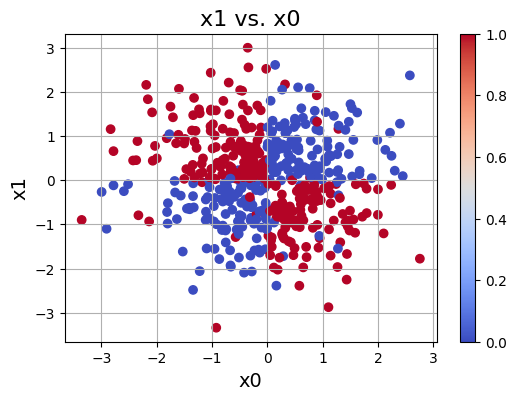

In [118]:
plt.figure(figsize=(6, 4))
plt.scatter(train['x0'], train['x1'], c=train['y'], cmap='coolwarm')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('x1 vs. x0', fontsize=16)
plt.colorbar()
plt.show()

# Mission 2.1
### 1. **Implementation**:

In [119]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [120]:
def lr_scheduler(step, warmup_steps=200, total_steps=10000 , max_lr=1e-1, min_lr=1e-5):
    if step < warmup_steps:
        # Linear warmup
        return max_lr * (step / warmup_steps)
    else:
        # Cosine decay
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        cosine = 0.5 * (1 + np.cos(np.pi * progress))
        return min_lr + (max_lr - min_lr) * cosine


Epoch     0 | Loss 0.7421 | Train Acc 0.4760 | Test Acc 0.5180 | LR 0.000000
Epoch   500 | Loss 0.1593 | Train Acc 0.9500 | Test Acc 0.9340 | LR 0.099040
Epoch  1000 | Loss 0.2052 | Train Acc 0.9340 | Test Acc 0.9120 | LR 0.093305
Epoch  1500 | Loss 0.1828 | Train Acc 0.9440 | Test Acc 0.9240 | LR 0.082976
Epoch  2000 | Loss 0.1801 | Train Acc 0.9460 | Test Acc 0.9280 | LR 0.069149
Epoch  2500 | Loss 0.1797 | Train Acc 0.9460 | Test Acc 0.9280 | LR 0.053290
Epoch  3000 | Loss 0.1781 | Train Acc 0.9440 | Test Acc 0.9280 | LR 0.037084
Epoch  3500 | Loss 0.1777 | Train Acc 0.9440 | Test Acc 0.9280 | LR 0.022248
Epoch  4000 | Loss 0.1775 | Train Acc 0.9440 | Test Acc 0.9260 | LR 0.010357
Epoch  4500 | Loss 0.1774 | Train Acc 0.9440 | Test Acc 0.9260 | LR 0.002673
Epoch  5000 | Loss 0.1774 | Train Acc 0.9440 | Test Acc 0.9260 | LR 0.000010


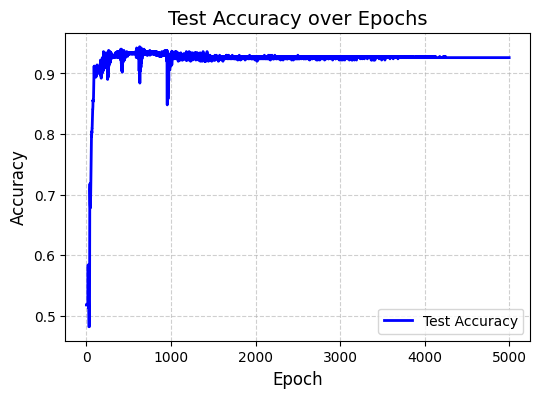

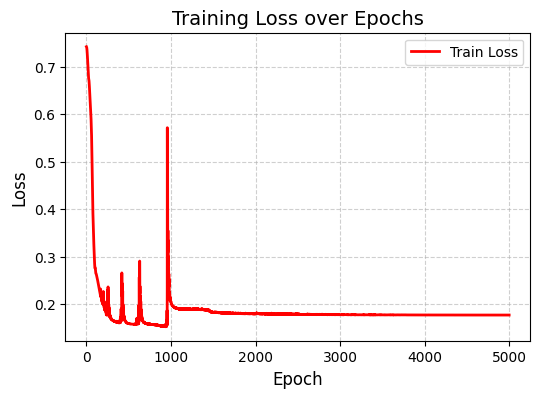

In [121]:
model = MLP()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
epochs = 5001

# Convert to tensors
X_train = torch.tensor(train[['x0', 'x1']].to_numpy(dtype=np.float32))
y_train = torch.tensor(train['y'].to_numpy(dtype=np.float32)).view(-1, 1)
X_test = torch.tensor(test[['x0', 'x1']].to_numpy(dtype=np.float32))
y_test = torch.tensor(test['y'].to_numpy(dtype=np.float32)).view(-1, 1)

def train_model(model, optimizer, criterion,
                X_train, y_train, X_test, y_test, lr_scheduler=None, epochs=5001):
    """
    Train a model and return logs of loss, accuracy, and learning rate.
    """

    # Logs
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    learning_rates = []

    global_step = 0
    for epoch in range(epochs):

        # Training step
        model.train()
        train_logits = model(X_train)
        train_loss = criterion(train_logits, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Scheduler
        if lr_scheduler:
            lr = lr_scheduler(global_step, total_steps=epochs)
            for g in optimizer.param_groups:
                g["lr"] = lr
        else:
            lr = optimizer.param_groups[0]["lr"]

        # Evaluation
        model.eval()
        with torch.no_grad():
            # Training metrics
            train_preds = (torch.sigmoid(train_logits) > 0.5).float()
            train_acc = (train_preds == y_train).float().mean().item()

            # Test metrics
            test_logits = model(X_test)
            test_loss = criterion(test_logits, y_test).item()
            test_preds = (torch.sigmoid(test_logits) > 0.5).float()
            test_acc = (test_preds == y_test).float().mean().item()

        # Logging
        train_losses.append(train_loss.item())
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        learning_rates.append(lr)

        global_step += 1

        if epoch % 500 == 0:
            print(
                f"Epoch {epoch:5d} | "
                f"Loss {train_loss.item():.4f} | "
                f"Train Acc {train_acc:.4f} | Test Acc {test_acc:.4f} | "
                f"LR {lr:.6f}"
            )

    return {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies,
        "learning_rates": learning_rates
    }

logs = train_model(model, optimizer, criterion,
                   X_train, y_train, X_test, y_test, lr_scheduler)

train_losses = logs["train_losses"]
test_losses = logs["test_losses"]
train_accuracies = logs["train_accuracies"]
test_accuracies = logs["test_accuracies"]
learning_rates = logs["learning_rates"]


# Plot test accuracy
plt.figure(figsize=(6,4))
plt.plot(test_accuracies, label="Test Accuracy", color="blue", linewidth=2)
plt.title("Test Accuracy over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss", color="red", linewidth=2)
plt.title("Training Loss over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


### 2. **Performance**:
As seen in the code cell below the test accuracy of the model is **0.9360** and satisfies the threshold of at least **0.92** in accuracy.



In [122]:
print(f"Test Accuracy: {test_accuracies[-1]:.4f}")

Test Accuracy: 0.9260


### 2. **Discussion**:
- How can you make sure the results are reproducible?
**Answer:** To make the results reproducible one can simply set `torch.manual_seed(42)` at the very beginning after `torch` is imported (which is done in this notebook).

- Visualize the network's architecture and decision boundary.

![alt text](mlp_architecture.png)
The architecture of this network's model has two input nodes (x0, x1),
two hidden layers with five neurons each, where each neuron computes a weighted sum
of its inputs followed by a ReLU,
and finally one output node (y_hat) that produces the prediction.
(Note: The picture with the network's architecture originates from a html, which was generated with chat-gpt.)


In [123]:
# Summary info of the model
summary(model, input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 5]              15
              ReLU-2                    [-1, 5]               0
            Linear-3                    [-1, 5]              30
              ReLU-4                    [-1, 5]               0
            Linear-5                    [-1, 1]               6
Total params: 51
Trainable params: 51
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


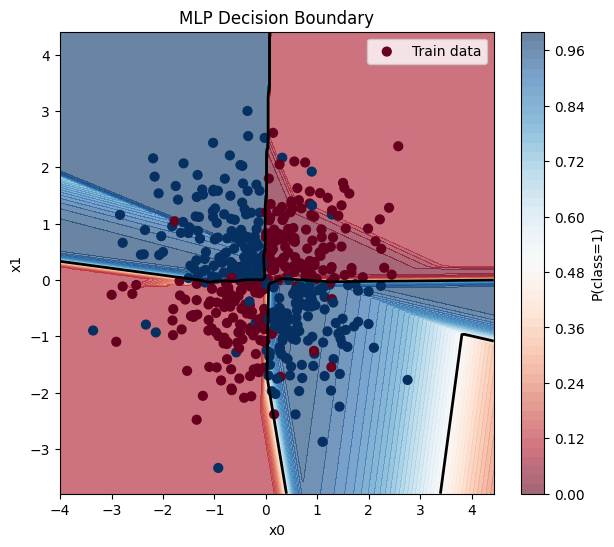

In [124]:
x_min, x_max = X_test[:,0].min() - 1, X_test[:,0].max() + 1
y_min, y_max = X_test[:,1].min() - 1, X_test[:,1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

# Predictions on grid
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    Z = torch.sigmoid(model(grid)).numpy().reshape(xx.shape)

plt.figure(figsize=(7,6))

# Decision regions
contour = plt.contourf(xx, yy, Z, levels=50, cmap=plt.cm.RdBu, alpha=0.6)
plt.colorbar(contour, label="P(class=1)")

# Decision boundary
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

# # Test points
# plt.scatter(
#     X_test[:,0], X_test[:,1],
#     c=y_test.numpy().ravel(),
#     cmap=plt.cm.RdBu,
#     s=40, marker='x',
#     label="Test data"
# )

# Train points
plt.scatter(
    X_train[:,0], X_train[:,1],
    c=y_train.numpy().ravel(),
    cmap=plt.cm.RdBu,
    s=40, marker='o',
    label="Train data"
)

plt.title("MLP Decision Boundary")
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()
plt.show()


Note: The Decision Boundary for the MLP might be overfitted as it captures some large areas where a few instances lies.

- Which optimizer did you choose? Discuss the differences between SGD and Adam.
**Answer:** In this task I used Adam since it often achieved higher test accuracy, which was required to meet the threshold criteria. However, SGD appeared more stable than Adam, as its loss and accuracy curves were smoother. This might also be influenced by the choice of learning rate. I observed that Adam can fail more quickly and get stuck in a local minimum if the learning rate is too high at the start, whereas SGD was not affected to the same extent. Nonetheless, I struggled to achieve sufficiently high test accuracy with SGD, and therefore I ultimately chose Adam.
 In general, the differences between SGD and Adam lie in their optimization approaches. SGD (Stochastic Gradient Descent) updates model weights using a fixed learning rate that is shared across all parameters. It computes gradients on mini-batches and applies them directly to the weights, which makes it simple and often stable but sensitive to learning rate choice. Adam (Adaptive Moment Estimation) is an adaptive optimizer that adjusts learning rates for each parameter individually. It maintains moving averages of past gradients and squared gradients to adaptively rescale updates. This often leads to faster convergence and higher accuracy in practice, but it can also be more sensitive to hyperparameter choices and less stable than SGD in some cases (like in this case).



- Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?
**Answer:** The learning rate curve is plotted below, and the results show that using a scheduler has a significant impact on performance. With the learning rate scheduler, the model reaches a test accuracy of **0.9360** in just 5000 epochs. In comparison, if the lines in the training loop that adjust the optimizer’s learning rate according to the scheduler are commented out, it takes around 15 000 epochs to reach a test accuracy of only **0.9300** (with a fixed learning rate of 0.0001). Thus, learning rate scheduling not only allows the model to converge faster but also helps it achieve a higher accuracy. However, it also has some shortcomings: if implemented incorrectly, or if the warmup stage is too long, the model can plateau or fall into a poor local minimum because it remains at a high learning rate for too long.


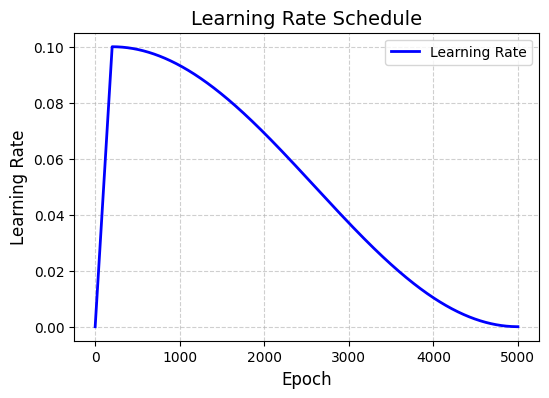

In [125]:
plt.figure(figsize=(6,4))
plt.plot(learning_rates, label="Learning Rate", color="blue", linewidth=2)
plt.title("Learning Rate Schedule", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Learning Rate", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

- Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.

In [126]:
# From original network with one hidden layer
class MLP_5_1Hidden(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# From original network with three hidden layers
class MLP_5_3Hidden(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)


class MLP_3(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 3),
            nn.ReLU(),
            nn.Linear(3, 3),
            nn.ReLU(),
            nn.Linear(3, 1)
        )

    def forward(self, x):
        return self.layers(x)


class MLP_7(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 7),
            nn.ReLU(),
            nn.Linear(7, 7),
            nn.ReLU(),
            nn.Linear(7, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [127]:
# Models to compare
architectures = {
    "MLP_5_1Hidden": MLP_5_1Hidden,
    "MLP_5_3Hidden": MLP_5_3Hidden,
    "MLP_3": MLP_3,
    "MLP_5": MLP,
    "MLP_7": MLP_7
}

# Optimizer setups
optimizers = ["SGD", "SGD+Scheduler", "Adam", "Adam+Scheduler"]

ablation_logs = {}

for arch_name, model_class in architectures.items():
    for opt_name in optimizers:
        print(f"\n--- Training {arch_name} with {opt_name} ---")

        model = model_class()

        # Optimizer choice
        if "SGD" in opt_name:
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        else:  # Adam
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        # Scheduler if "+LR" is in the name
        scheduler = lr_scheduler if "+LR" in opt_name else None

        # Train and store logs
        logs = train_model(
            model, optimizer, criterion,
            X_train, y_train, X_test, y_test,
            lr_scheduler=scheduler,
            epochs=epochs
        )

        ablation_logs[(arch_name, opt_name)] = logs


--- Training MLP_5_1Hidden with SGD ---
Epoch     0 | Loss 0.7233 | Train Acc 0.4420 | Test Acc 0.4680 | LR 0.010000
Epoch   500 | Loss 0.5321 | Train Acc 0.8200 | Test Acc 0.7840 | LR 0.010000
Epoch  1000 | Loss 0.3459 | Train Acc 0.9140 | Test Acc 0.9040 | LR 0.010000
Epoch  1500 | Loss 0.3346 | Train Acc 0.9340 | Test Acc 0.9100 | LR 0.010000
Epoch  2000 | Loss 0.3334 | Train Acc 0.9360 | Test Acc 0.9080 | LR 0.010000
Epoch  2500 | Loss 0.3331 | Train Acc 0.9360 | Test Acc 0.9100 | LR 0.010000
Epoch  3000 | Loss 0.3330 | Train Acc 0.9360 | Test Acc 0.9120 | LR 0.010000
Epoch  3500 | Loss 0.3330 | Train Acc 0.9360 | Test Acc 0.9120 | LR 0.010000
Epoch  4000 | Loss 0.3330 | Train Acc 0.9360 | Test Acc 0.9120 | LR 0.010000
Epoch  4500 | Loss 0.3330 | Train Acc 0.9360 | Test Acc 0.9120 | LR 0.010000
Epoch  5000 | Loss 0.3330 | Train Acc 0.9340 | Test Acc 0.9120 | LR 0.010000

--- Training MLP_5_1Hidden with SGD+Scheduler ---
Epoch     0 | Loss 0.7219 | Train Acc 0.4760 | Test Acc 0.424

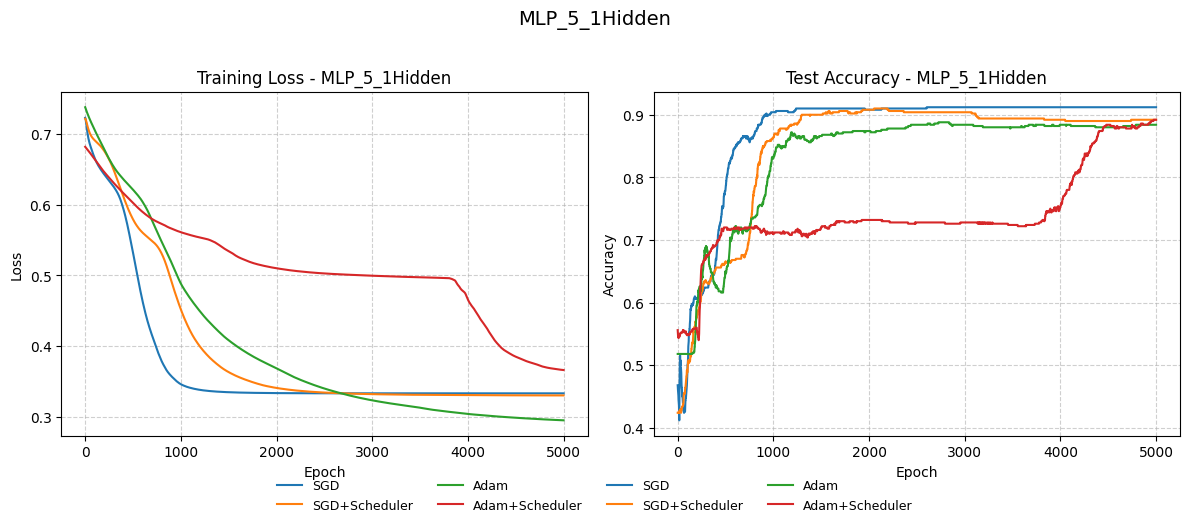

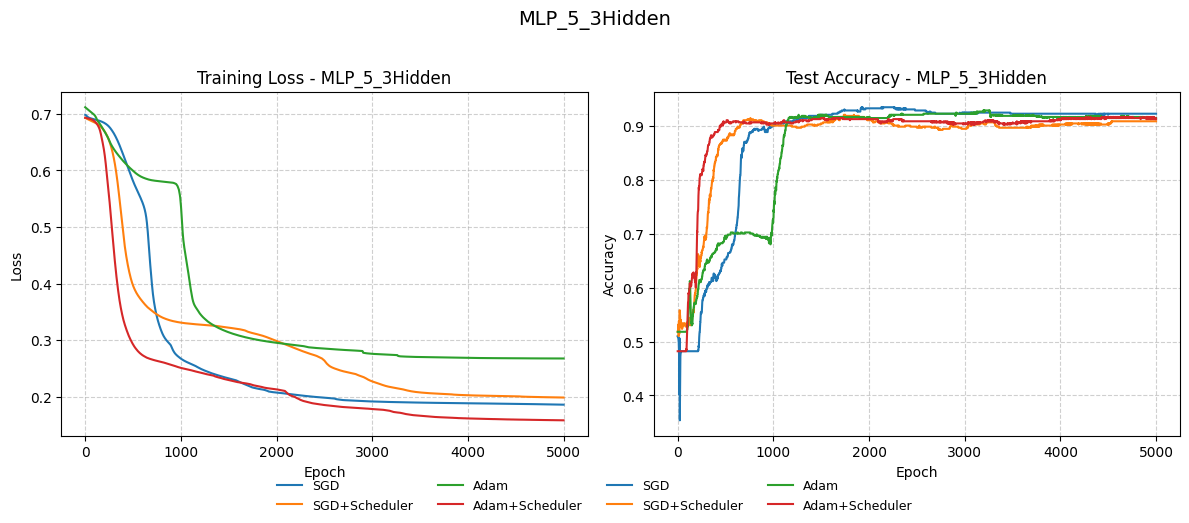

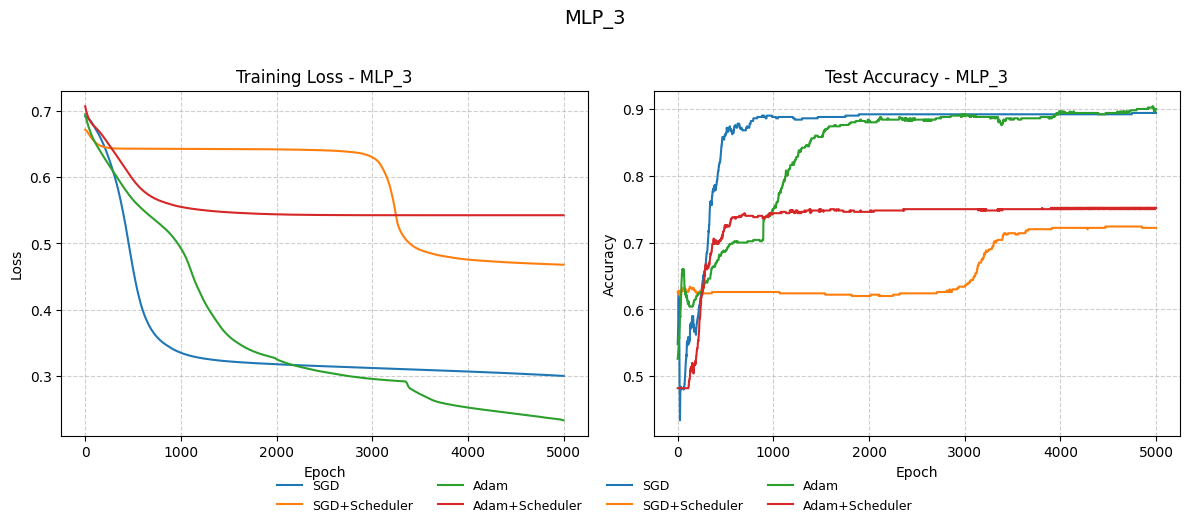

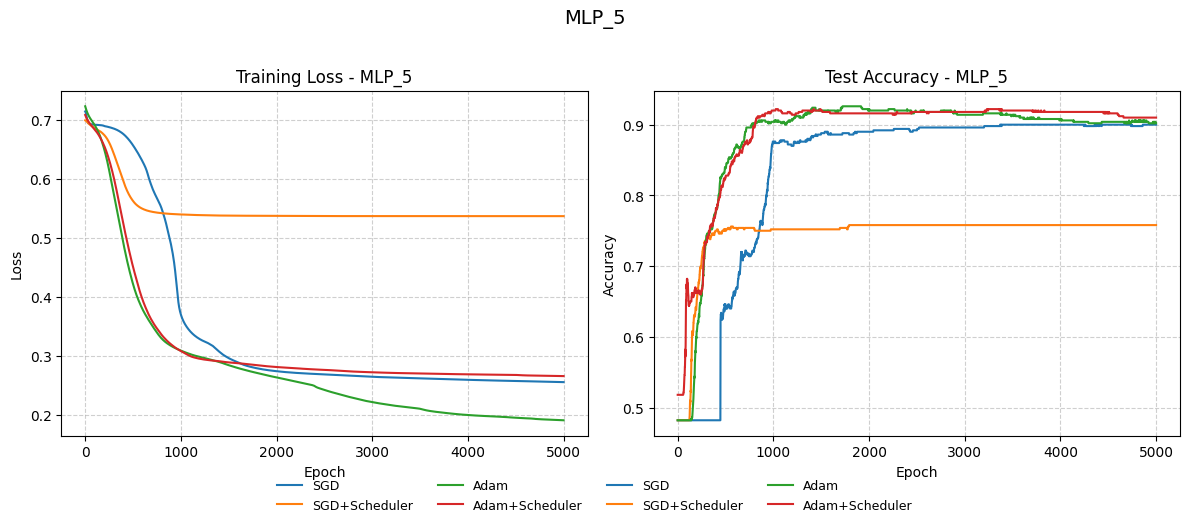

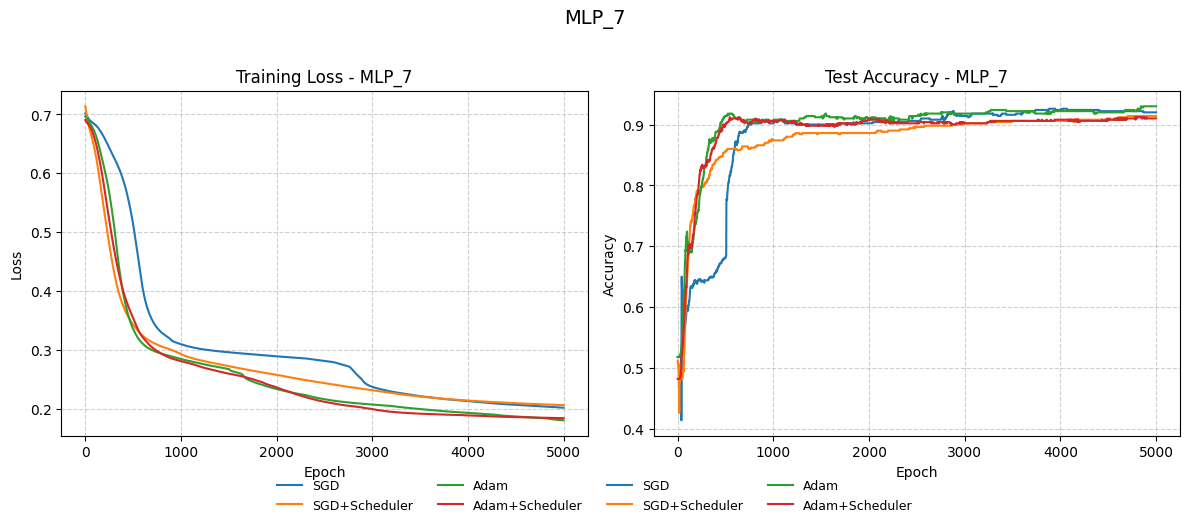

In [128]:
# One subplot (loss + accuracy) per model, showing all optimizer variants
styles = {'SGD': '-', 'SGD+Scheduler': ':', 'Adam': '--', 'Adam+Scheduler': '-.'}

for arch_name in architectures.keys():
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # --- Training Loss ---
    ax = axes[0]
    for opt_name in optimizers:
        key = (arch_name, opt_name)
        if key in ablation_logs:
            logs = ablation_logs[key]
            ax.plot(
                logs["train_losses"],
                linestyle='-',
                label=opt_name
            )
    ax.set_title(f"Training Loss - {arch_name}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True, linestyle="--", alpha=0.6)

    # --- Test Accuracy ---
    ax = axes[1]
    for opt_name in optimizers:
        key = (arch_name, opt_name)
        if key in ablation_logs:
            logs = ablation_logs[key]
            ax.plot(
                logs["test_accuracies"],
                linestyle='-',
                label=opt_name
            )
    ax.set_title(f"Test Accuracy - {arch_name}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.grid(True, linestyle="--", alpha=0.6)

    # Legend only once, below the plots
    fig.legend(loc="lower center", ncol=len(optimizers), fontsize=9, frameon=False)
    plt.suptitle(f"{arch_name}", fontsize=14, y=1.02)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()


In [129]:
sorted_runs = sorted(
    ablation_logs.items(),
    key=lambda kv: kv[1]["test_accuracies"][-1],
    reverse=True
)

for i, ((arch, opt), logs) in enumerate(sorted_runs, start=1):
    acc = logs["test_accuracies"][-1]
    print(f"{i:2d}. {arch:<14} {opt:<15} → Test Accuracy: {acc:.3f}")

 1. MLP_7          Adam            → Test Accuracy: 0.930
 2. MLP_5_3Hidden  SGD             → Test Accuracy: 0.922
 3. MLP_7          SGD             → Test Accuracy: 0.920
 4. MLP_5_3Hidden  Adam            → Test Accuracy: 0.914
 5. MLP_7          SGD+Scheduler   → Test Accuracy: 0.914
 6. MLP_5_1Hidden  SGD             → Test Accuracy: 0.912
 7. MLP_5_3Hidden  Adam+Scheduler  → Test Accuracy: 0.912
 8. MLP_5          Adam+Scheduler  → Test Accuracy: 0.910
 9. MLP_7          Adam+Scheduler  → Test Accuracy: 0.910
10. MLP_5_3Hidden  SGD+Scheduler   → Test Accuracy: 0.908
11. MLP_5          Adam            → Test Accuracy: 0.902
12. MLP_3          Adam            → Test Accuracy: 0.900
13. MLP_5          SGD             → Test Accuracy: 0.900
14. MLP_3          SGD             → Test Accuracy: 0.894
15. MLP_5_1Hidden  SGD+Scheduler   → Test Accuracy: 0.892
16. MLP_5_1Hidden  Adam+Scheduler  → Test Accuracy: 0.892
17. MLP_5_1Hidden  Adam            → Test Accuracy: 0.884
18. MLP_5     

Based on the results from the ablation study, the **MLP_7** model trained with Adam achieved the highest test accuracy of **0.9300**. At first glance this might seem surprising, since the original **MLP_5 Adam+Scheduler** model had previously reached **0.9360**. However, since the models are retrained from scratch, some variation in the results is expected.
Overall, the study suggests that increasing the number of hidden layers and nodes tends to improve accuracy compared to shallower architectures. It also appears that combining Adam with a learning rate scheduler performs better than using SGD with scheduling. Taken together, this indicates that the originally chosen architecture was already close to optimal, even if it may not be the absolute best. At the same time, it is worth noting that using identical learning rate and scheduler settings across all architectures could have constrained the performance for some of the models.


# 📶📡🛰️🤳 Mission 2.2: Locate the AI Servers

### 🌐 The Discovery
The NTNU Intelligence team has intercepted encrypted documentation that potentially reveals the locations of AI-compromised servers within Trondheim. Our analysts believe the data contains information about these servers' locations. 

However, the number of servers and their exact positions remain unknown. To execute a strategic response, we need to understand the intercepted data and pinpoint the main AI servers.

We have also discovered a vulnerability in the AI's security: it has deployed a clustering verification feature on Kaggle. We can exploit this backdoor to validate our clustering hypotheses.

### 🎯 Your Mission
Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle.  When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge
1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.


### 🚀 Your Tools
- The intercepted AI dataset.
- Skills in feature engineering, data manipulation, and visualization.
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts.

> Note: Kaggle competition link — [Kaggle Competition](https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc)

### 📊 Formal Requirements
1. **Achieve 100% Clustering Accuracy** on Kaggle.
> Note: The only way to check whether your clustering is correct is to submit it to Kaggle. We do not give you the clusters directly.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.

In [130]:
# Hmmmmm, why is the first row skipped?
data = pd.read_csv('unsupervised_data.csv', skiprows=1, header=None)
# Get the ID column
data.reset_index(drop=False, inplace=True)
data.rename(columns={'index': 'ID'}, inplace=True)
data

,ID,0,1,2,3,4,5,6,7,8,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0,0.314365,0.646305,0.323849,0.238492,0.655790,0.646305,0.646305,0.409205,0.646305,...,0.646305,0.646305,0.655790,0.238492,0.646305,0.674758,0.646305,0.238492,0.655790,0.646305
1,1,0.587628,0.494976,0.559832,-0.246237,0.513506,0.550567,0.522772,0.596893,0.606158,...,0.587628,0.550567,0.587628,0.587628,0.550567,0.587628,0.550567,0.596893,0.494976,0.587628
2,2,0.590203,0.367673,0.367673,0.367673,0.367673,0.590203,0.367673,0.590203,0.590203,...,0.590203,0.367673,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.476556
3,3,0.589296,0.589296,0.579825,0.551415,0.579825,0.579825,0.608236,0.579825,0.646118,...,0.532474,0.523003,0.589296,0.589296,0.551415,0.134721,0.475652,0.589296,0.570355,0.551415
4,4,0.660095,0.470676,0.190366,0.672806,0.470761,0.672766,0.672652,0.666151,0.672987,...,0.432001,0.672222,0.190568,0.217329,0.633684,0.673294,0.587914,0.671023,0.207578,0.470765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,0.340739,0.340739,0.340739,0.681823,0.340739,0.340739,0.340739,0.672083,0.340739,...,0.340739,0.662355,0.340739,0.759779,0.331011,0.759779,0.340739,0.691563,0.340734,0.720789
3996,3996,0.384257,0.384257,0.675221,0.384257,0.384257,0.675221,0.384257,0.675221,0.675221,...,0.675221,0.384257,0.675221,0.675221,0.675221,0.384257,0.384257,0.384257,0.675221,0.675221
3997,3997,0.641837,0.651135,0.251329,0.251329,0.651135,0.651135,0.251329,0.651135,0.651135,...,0.251329,0.251329,0.651135,0.251329,0.409392,0.604646,0.651135,0.651135,0.660433,0.251329
3998,3998,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,-0.212897,0.555533,...,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533


In [131]:
# The dataset is heavy. Applying clustering directly on the dataset is likely not feasible. 
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 16385 entries, ID to 16383
dtypes: float64(16384), int64(1)
memory usage: 500.0 MB


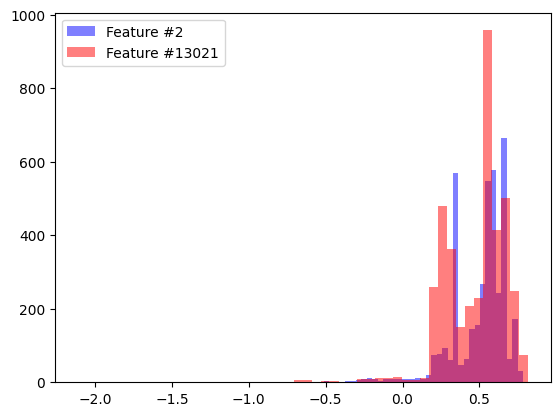

In [132]:
# Features seem to be similarly distributed...
plt.hist(data.iloc[:, 2], bins=50, color='blue', alpha=0.5, label='Feature #2')
plt.hist(data.iloc[:, 13021], bins=50, color='red', alpha=0.5, label='Feature #13021')
plt.legend()
plt.show()

In [133]:
# To check your clustering, you need to assign the predicted cluster ids and submit it as a CSV file. The submission should be a CSV file with two columns: ID and cluster. 
# The ID column should contain the ID of the data point, and the cluster column should contain the cluster ID that the data point belongs to. 
# The cluster ID should be an integer. Current cluster IDs in sample_submission.csv are randomly generated.
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,ID,cluster
0,0,2
1,1,6
2,2,3
3,3,3
4,4,8
...,...,...
3995,3995,3
3996,3996,7
3997,3997,3
3998,3998,7



---

## 🎯 Note: Clustering Accuracy Evaluation

The clustering accuracy metric evaluates how well the predicted clusters match the true clusters, irrespective of the specific labels or names assigned to the clusters.

This means that the evaluation is solely based on the correct grouping of data points rather than the numerical labels of the clusters themselves.

## Key Characteristics

- **Name-Independent**: The metric cares only about how well the data points are grouped together, not the specific numerical or categorical labels used for the clusters.
- **Focus on Grouping**: The evaluation rewards cluster assignments that correctly group the same data points together, regardless of the specific labels assigned.

### Example

If the true cluster assignments are:

```
[0, 0, 0, 1, 1, 1]
```

and your predicted cluster assignments are:

```
[1, 1, 1, 0, 0, 0]
```

the accuracy will still be **1.0** because the grouping of points is identical, even though the numerical labels are swapped.

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---

In [134]:


def calculate_clustering_accuracy(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
    """
    Calculate the clustering accuracy between true labels and cluster labels.

    The function constructs a contingency matrix between the true labels and cluster labels.
    It then uses the Hungarian algorithm (also known as linear sum assignment) to find the
    best matching between the cluster labels and true labels. The clustering accuracy is 
    calculated as the number of correctly matched labels divided by the total number of labels.

    Args:
        true_labels (np.ndarray): An array of true labels for each data point.
        cluster_labels (np.ndarray): An array of cluster labels predicted by a clustering algorithm.

    Returns:
        float: The clustering accuracy, a value between 0 and 1 representing the proportion of 
               correctly matched labels.
    
    Example:
        >>> true_labels = np.array([0, 1, 2, 0, 1, 2])
        >>> cluster_labels = np.array([1, 2, 0, 1, 2, 0])
        >>> calculate_clustering_accuracy(true_labels, cluster_labels)
        1.0

    Raises:
        ValueError: If true_labels and cluster_labels are not of the same length.
    """
    # Check if the input labels are of the same length
    if true_labels.size != cluster_labels.size:
        raise ValueError("true_labels and cluster_labels must have the same length.")

    # Construct a contingency matrix where each cell [i, j] indicates the number of points with 
    # true label i and cluster label j.
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(true_labels, cluster_labels)
    
    # Find the best matching between true labels and cluster labels using the Hungarian algorithm.
    # We negate the contingency matrix because linear_sum_assignment finds the minimum cost assignment.
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-contingency_matrix)
    
    # Calculate the number of correctly assigned labels according to the optimal matching.
    correct_pairs = contingency_matrix[row_ind, col_ind].sum()
    
    # Compute the clustering accuracy as the ratio of correctly matched labels to total labels.
    accuracy = correct_pairs / true_labels.size

    return accuracy

In [135]:
true_labels = np.array([0, 1, 2, 0, 1, 2])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

1.0

In [136]:
true_labels = np.array([0, 0, 0, 0, 0, 0])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

0.3333333333333333

In [137]:
true_labels = np.array([1, 1, 1, 2, 2, 2])
cluster_labels = np.array([0, 0, 0, 0, 0, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

0.5

# Mission 2.2
### 1. **Achieve 100% Clustering Accuracy** on Kaggle.

(Trying around with different dimension reduction techniques. Mainly for discussion)

##### PCA

In [138]:
X = data.drop(columns=['ID']).values

pca = PCA(n_components=30, random_state=42)
X_pca = pca.fit_transform(X)

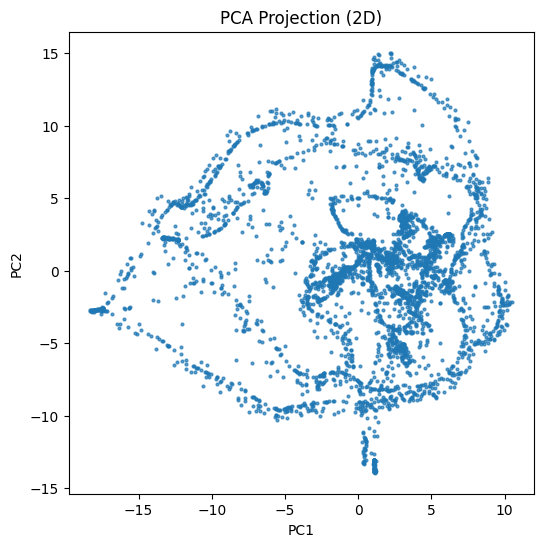

In [139]:
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=4, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection (2D)")
plt.show()

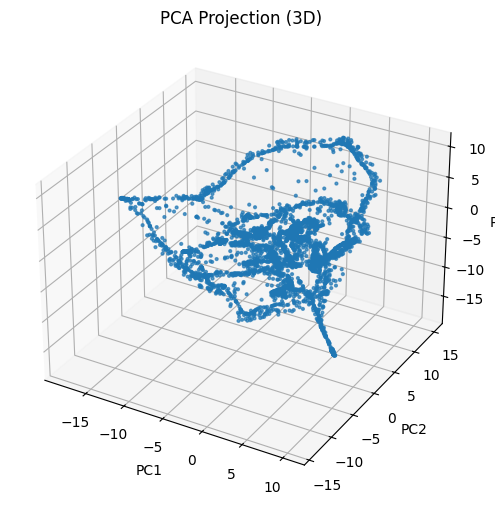

In [140]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    s=4,
    alpha=0.7,
)
ax.set_title("PCA Projection (3D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

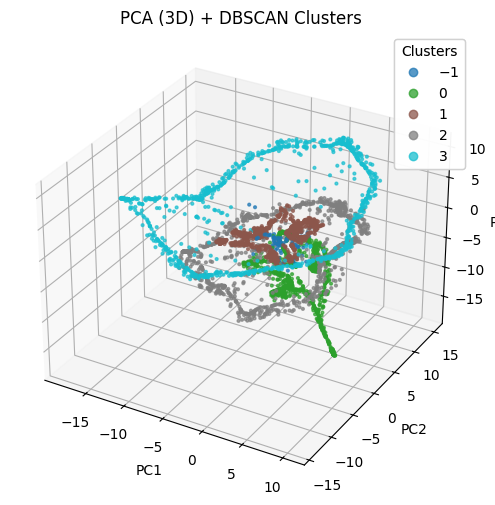

In [141]:
# DBSCAN clustering
dbscan = DBSCAN(eps=8, min_samples=8)
clusters = dbscan.fit_predict(X_pca)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=clusters,
    cmap="tab10",
    s=4,
    alpha=0.7
)
ax.set_title("PCA (3D) + DBSCAN Clusters")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()

Looks somewhat promising. Actually provides a 97.8 accuracy on Kaggle

In [142]:
submission = pd.DataFrame({
    "ID": data["ID"],
    "cluster": clusters
})
submission.to_csv("submission_PCA.csv", index=False)

##### t-SNE

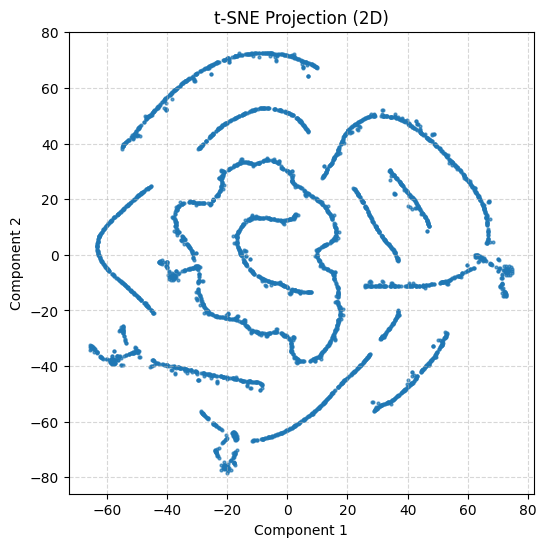

In [143]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=4, alpha=0.7, c='tab:blue')
plt.title("t-SNE Projection (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

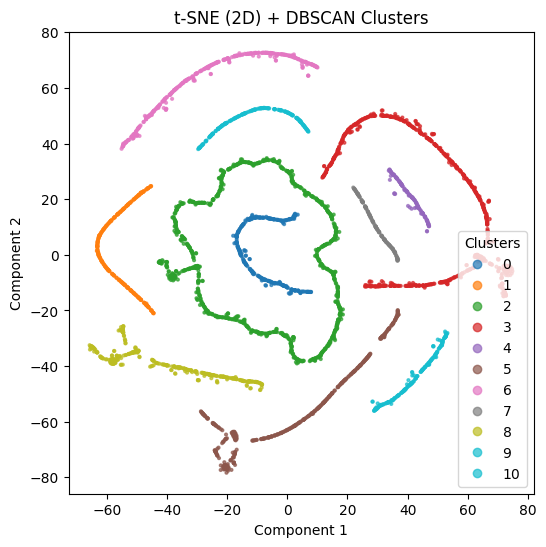

In [144]:
# DBSCAN clustering
dbscan = DBSCAN(eps=7, min_samples=8)
clusters = dbscan.fit_predict(X_tsne)

plt.figure(figsize=(6, 6))
scatter = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=clusters,
    cmap="tab10",
    s=4,
    alpha=0.7
)
plt.title("t-SNE (2D) + DBSCAN Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

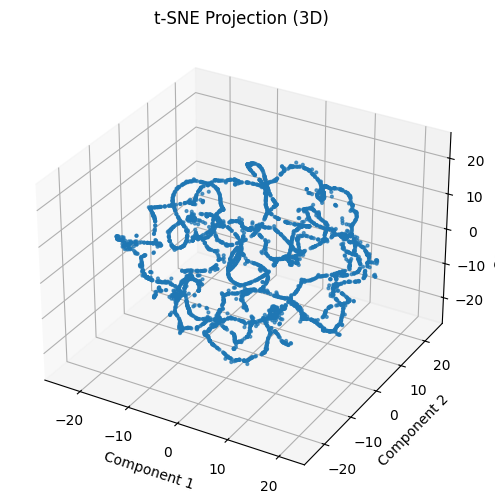

In [145]:
# t-SNE (3D)
tsne3d = TSNE(n_components=3, random_state=42)
X_tsne3d = tsne3d.fit_transform(X)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    X_tsne3d[:, 0],
    X_tsne3d[:, 1],
    X_tsne3d[:, 2],
    s=4,
    alpha=0.7,
    c='tab:blue'
)
ax.set_title("t-SNE Projection (3D)")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.show()

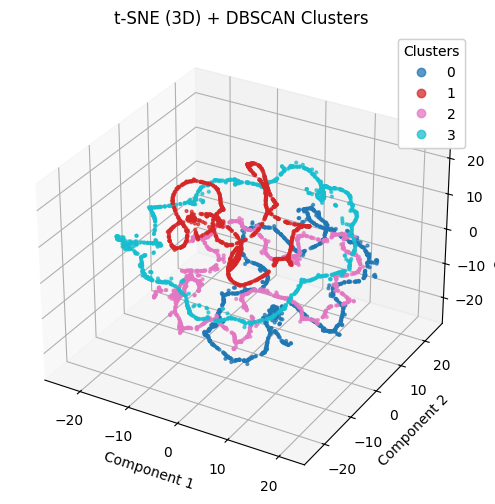

In [146]:
# DBSCAN clustering
dbscan = DBSCAN(eps=5, min_samples=8)
clusters = dbscan.fit_predict(X_tsne3d)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    X_tsne3d[:, 0],
    X_tsne3d[:, 1],
    X_tsne3d[:, 2],
    c=clusters,
    cmap="tab10",
    s=4,
    alpha=0.7
)
ax.set_title("t-SNE (3D) + DBSCAN Clusters")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()

t-SNE dimension reduction into 3D looks very promising.

In [147]:
submission = pd.DataFrame({
    "ID": data["ID"],
    "cluster": clusters
})
submission.to_csv("submission_tSNE.csv", index=False)

Provides a 100% cluster accuracy on Kaggle

##### UMAP

C:\Users\jensc\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


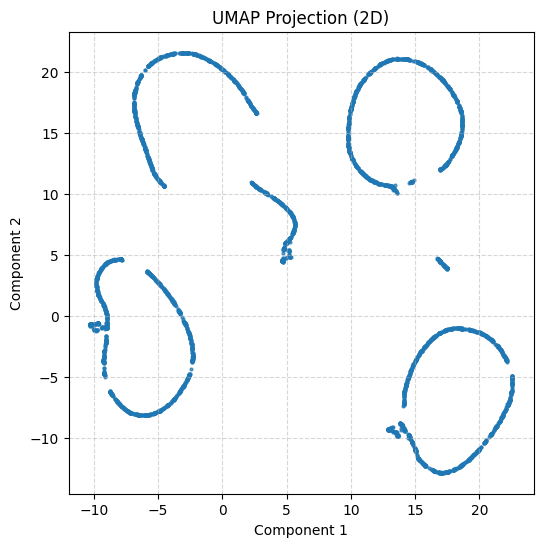

In [148]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X_umap[:,0], X_umap[:,1], s=4, alpha=0.7)
plt.title("UMAP Projection (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

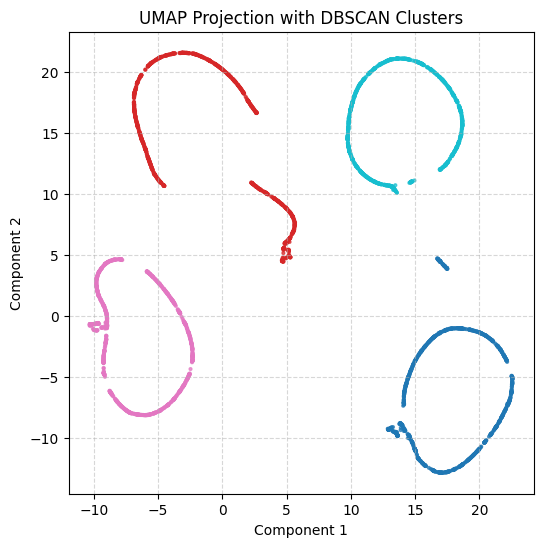

In [149]:
# DBSCAN clustering
dbscan = DBSCAN(eps=6, min_samples=10)
clusters = dbscan.fit_predict(X_umap)

plt.figure(figsize=(6,6))
plt.scatter(
    X_umap[:,0], X_umap[:,1],
    c=clusters, cmap="tab10", s=4, alpha=0.7
)
plt.title("UMAP Projection with DBSCAN Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

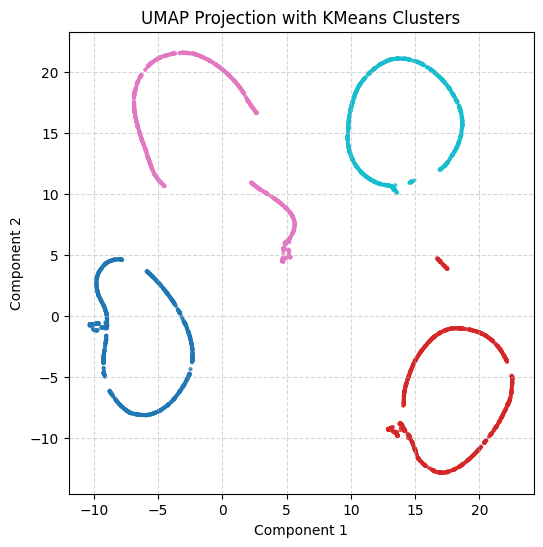

In [150]:
# KMeans clustering with 4 clusters (observed from previous plots)
kmeans = KMeans(n_clusters=4, n_init="auto", random_state=42)
clusters = kmeans.fit_predict(X_umap)

plt.figure(figsize=(6,6))
plt.scatter(
    X_umap[:,0], X_umap[:,1],
    c=clusters, cmap="tab10", s=4, alpha=0.7
)
plt.title("UMAP Projection with KMeans Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

The clusters from UMAP, calculated with both Kmeans and DBSCAN seems promising.

In [151]:
submission = pd.DataFrame({
    "ID": data["ID"],
    "cluster": clusters
})
submission.to_csv("submission.csv", index=False)

The result from Kaggle showed a 100% accuracy

- **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
**Answer:**
The dimensionality reduction method that primarily helped determine the number of clusters was UMAP. I was able to get some indications of the number of clusters from PCA (3D) and t-SNE (3D), but UMAP (2D) provided the clearest separation between clusters and also achieved the best clustering accuracy on Kaggle (together with t-SNE in 3D).
The difference between PCA, t-SNE, and UMAP lies in how they preserve structure in the data. PCA is a linear method that projects data onto new axes (principal components) which maximize variance. This means PCA preserves the global structure of the dataset but may miss subtle local patterns, especially in non-linear data. t-SNE, on the other hand, is a non-linear method that models pairwise similarities as probabilities and minimizes the KL divergence between high- and low-dimensional spaces. This makes it very good at preserving local neighborhoods, so similar points stay close together in the embedding. However, t-SNE can distort global distances, making it harder to judge large-scale relationships. UMAP is also non-linear and focuses on local relationships like t-SNE, but it is more efficient and tends to preserve more global structure at the same time. It scales better to large datasets and often produces embeddings that are both more interpretable and more useful for clustering.


- **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
**Answer:**
The clustering algorithm I used for this task was DBSCAN. I chose DBSCAN because the clusters in the dataset were not necessarily spherical or evenly sized, and DBSCAN is particularly effective at finding clusters of arbitrary shapes and separating out noise points. The hyperparameters I used in DBSCAN are `eps` (the neighborhood radius) and `min_samples` (the minimum number of points required to form a dense region). By tuning these values, I was able to reveal a clear clustering structure in the reduced feature space.
In contrast, KMeans assumes clusters are spherical and of similar size. It requires specifying the number of clusters beforehand, which can be a limitation if the true number of clusters is unknown. DBSCAN, on the other hand, does not require the number of clusters to be set in advance and can detect outliers as noise, but it is sensitive to the choice of hyperparameters.
Overall, DBSCAN worked better for this dataset because the clusters appeared to be arranged in irregular patterns rather than compact, round groups.




- Data Type Analysis: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
**Answer:**
The hidden data type in the dataset is images of the four locations. Each image is 128x128 pixels, which explains why the dataset contains that many columns (128x128 = 16384). Since image data is highly non-linear, PCA, which relies on linear combinations of features, is not very effective. In contrast, t-SNE and UMAP preserve local neighborhoods, making them more suitable for capturing similarities between images and revealing clearer cluster structures.

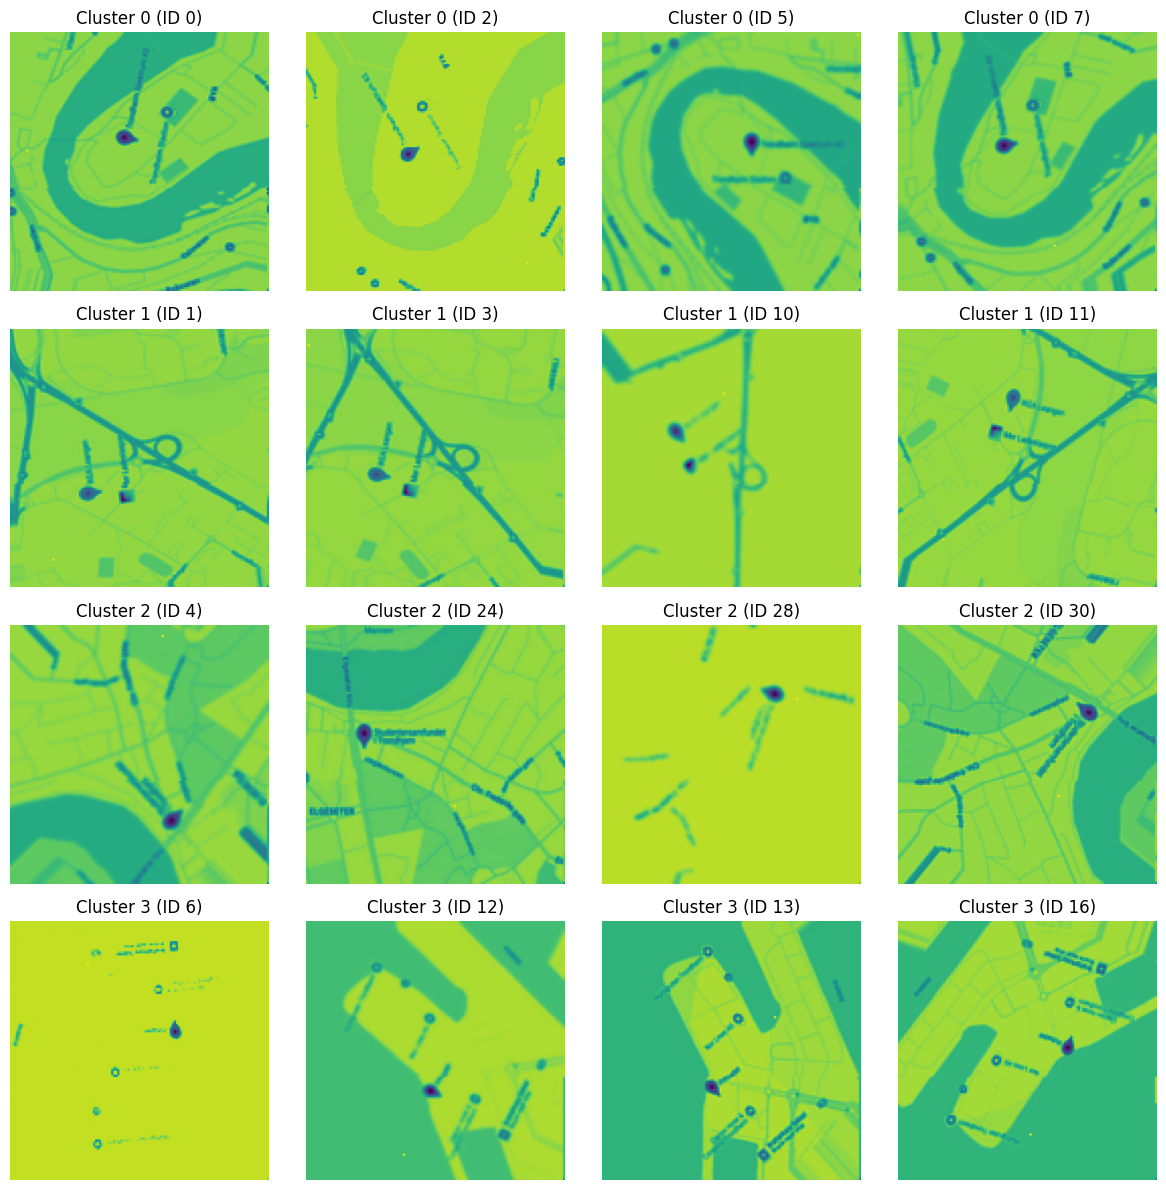

In [152]:
submission = pd.read_csv("submission7.csv")
data = pd.read_csv("unsupervised_data.csv")

# Sort numeric columns
cols = data.columns[1:]
col_indices = np.array([int(c[4:]) for c in cols])
sorted_cols = cols[np.argsort(col_indices)]

# Find the first 4 IDs for each cluster (0,1,2,3)
cluster_ids = []
for cluster_label in [0, 1, 2, 3]:
    ids = submission[submission["cluster"] == cluster_label]["ID"].head(4).tolist()
    cluster_ids.extend(ids)

# Plot 4 images for each cluster
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i, cluster_id in enumerate(cluster_ids):
    row_array = data[sorted_cols].iloc[cluster_id].to_numpy()
    row_array = np.append(row_array, 0)
    image = row_array.reshape(128, 128)
    axes[i].imshow(image, cmap="viridis")
    cluster_label = submission.loc[submission["ID"] == cluster_id, "cluster"].values[0]
    axes[i].set_title(f"Cluster {cluster_label} (ID {cluster_id})")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


- **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
**Answer:** By comparing the locations pattern with a tool like Google Maps, we can conclude that the servers are located at:
  - Trondheim Spektrum (Cluster 0)
  - Ikea Leangen       (Cluster 1)
  - Samfunnet          (Cluster 2)
  - Pirbadet           (Cluster 3)